# Lab 4: Classifier training & evaluation

I will train a SVM and random forest classifier to predict whether a seed is a Kama seed or not. The `type` column is the target for classification. The type column initially has three possible values: 1 (Kama seed), 2 (Rosa) or 3 (Canadian). But will be altered so that 0 represents **not a Kama seed**, and 1 represents **is a Kama seed**.

Towards the end of this notebook, I train and evaluate an MLPClassifier.

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### EDA

In [2]:
df = pd.read_csv("./seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [3]:
df.tail()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


In [4]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

### Transform `type` column to binary

In [5]:
mapper = {1: 1, 2: 0, 3: 0}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

### Check for missing values

In [6]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values. Let's check the boxplots of the numerical columns for outliers.

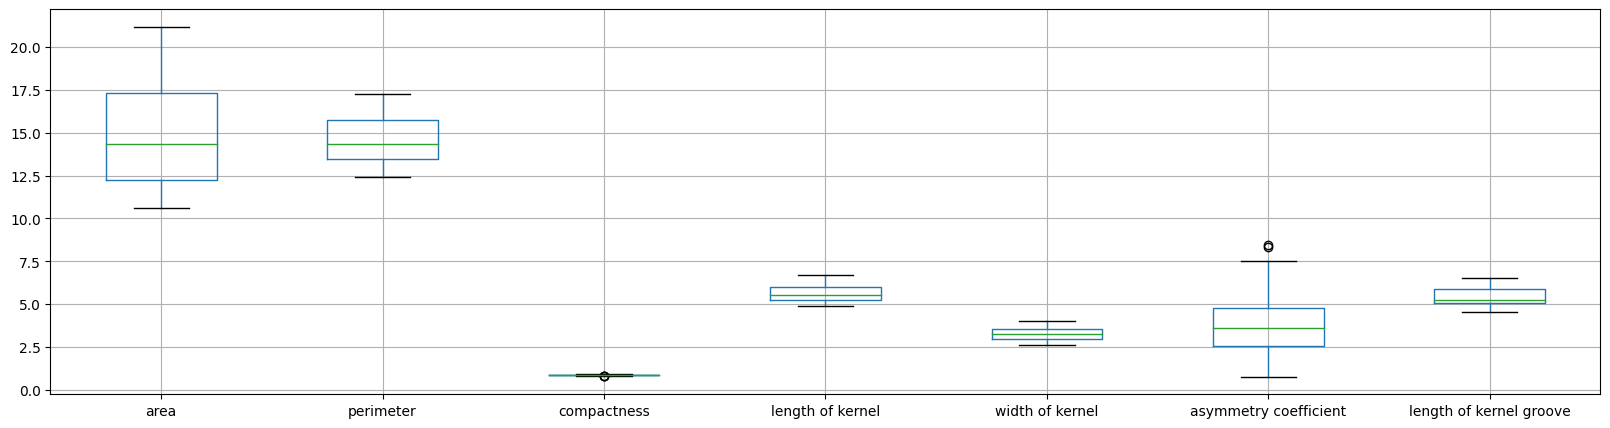

In [7]:
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

The `asymmetry coefficient` column contains an outlier, however it isn't very significant and I would argue it doesn't warrant log transformation or Robust Scaling. I will apply Standard scaling to all columns.

In [9]:
# Store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]
print(names_all)

['area', 'perimeter', 'compactness', 'length of kernel', 'width of kernel', 'asymmetry coefficient', 'length of kernel groove']


We will use the following class in the preprocessing pipeline to put the names of the columns back.

In [10]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

We need another class to be able to select a particular group of columns.

In [11]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Now we build the preprocessing pipeline.

In [12]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    make_pipeline(
        ColumnSelector(columns=names_all),
        StandardScaler()
    )
)

Now we can separate the columns into target and predictors & split the dataset into a training and test set.

In [13]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### Grid search to find the best parameters for the classifiers

In [14]:

pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) 

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.953:
Best parameters:  {'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


Repeat the experiment with the Random Forest classifier.

In [15]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.911:
Best parameters:  {'rf__max_depth': 4, 'rf__n_estimators': 30}


### Compare the classifiers on the test set

To plot ROC curves for the models, we need to ensure that the same fpr (false positive rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1.

In [16]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [17]:
def evaluate_model(X_test, y_test, model):

    _probabilities = model.predict_proba(X_test)[:, 1]

    _predicted_values = model.predict(X_test)
        
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Use the above function to evaluate the best SVM and Random Forest models.

In [18]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

Use a pandas bar plot to compare the accuracy, precision, recall and F1-scores of both models. 

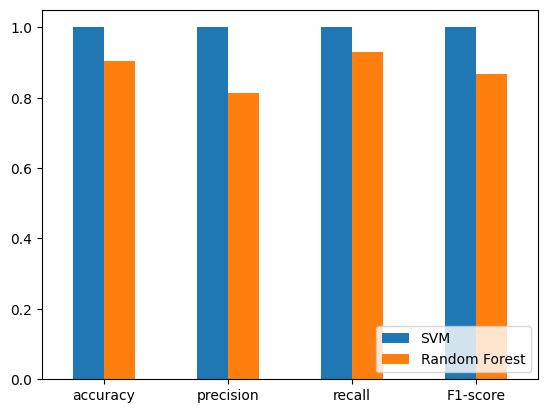

In [19]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

The SVM model performs  noticably better than the Random Forest model in terms of accuracy, precision, recall and F1-Score.

Examine the ROC curves of the two classifiers

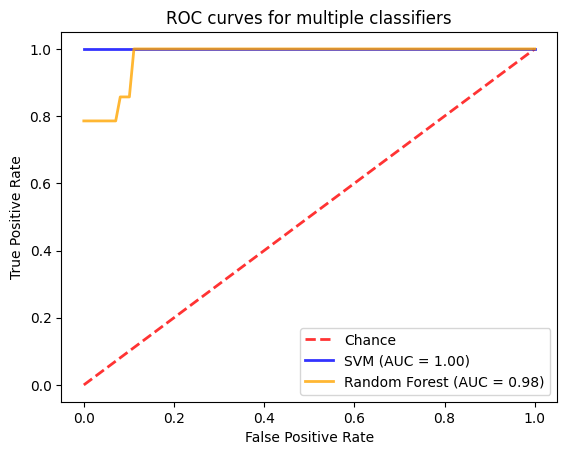

In [20]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

While both models perform significantly better than a random guess, the SVM model is noticably better than the Random Forest model.

### Train a final model

In [21]:
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

Store this model on disk

In [22]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

# Implement MLPClassifier

### Grid search to find the best parameters for the MLPClassifier

In [28]:
from sklearn.neural_network import MLPClassifier

# create the MLP classifier
mlp = MLPClassifier(max_iter=1000, random_state=42)

pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('mlp', mlp)])

param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['logistic', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(mlp, param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# store the best params and best model for later use
MLP_best_params = grid_search.best_params_
MLP_best_model = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters:  {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
Best score:  0.9527629233511586


c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Evaluate the best MLP Classifier model

In [30]:
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

Use a pandas bar plot to compare the accuracy, precision, recall and F1-scores of all models. 

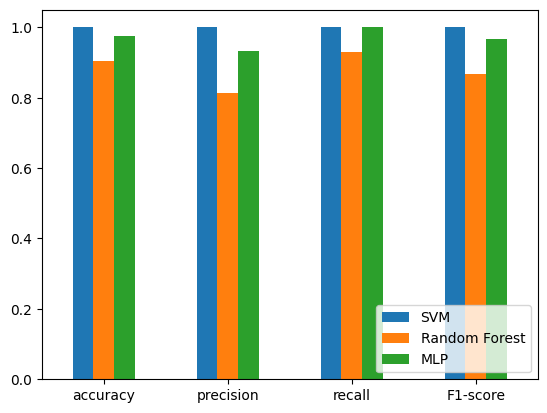

In [32]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'MLP': MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

The MLP Classifier model has very similar recall to the SVM model, but the SVM model still performs better in terms of accuracy, precision and F1-Score.

Examine ROC curves of all models

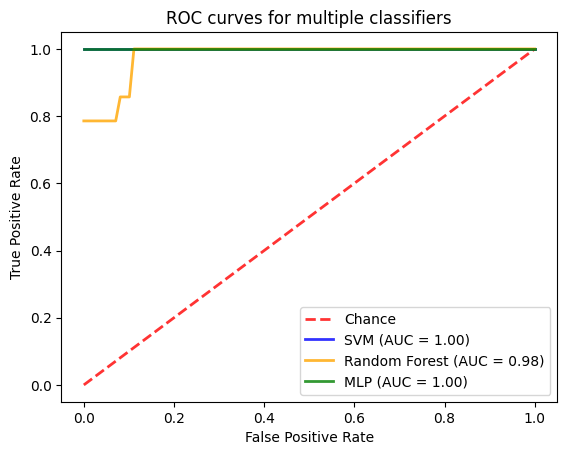

In [33]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='green', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The SVM and MLP models have very similar ROC Curves.

Train MLP model using all data

In [34]:
def transform(dict):
    return {key.replace('mlp__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, MLPClassifier(**transform(MLP_best_params)))

final_model =pipe.fit(X, y)

Save the MLP model to disk

In [35]:
filename = 'final_mlp_model.sav'
pickle.dump(final_model, open(filename, 'wb'))